Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        6.1e+05 s    Elapsed time so far: 24.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.7e+05 s    Elapsed time so far: 20.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        6.1e+05 s    Elapsed time so far: 28.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.7e+05 s    Elapsed time so far: 17.4 s


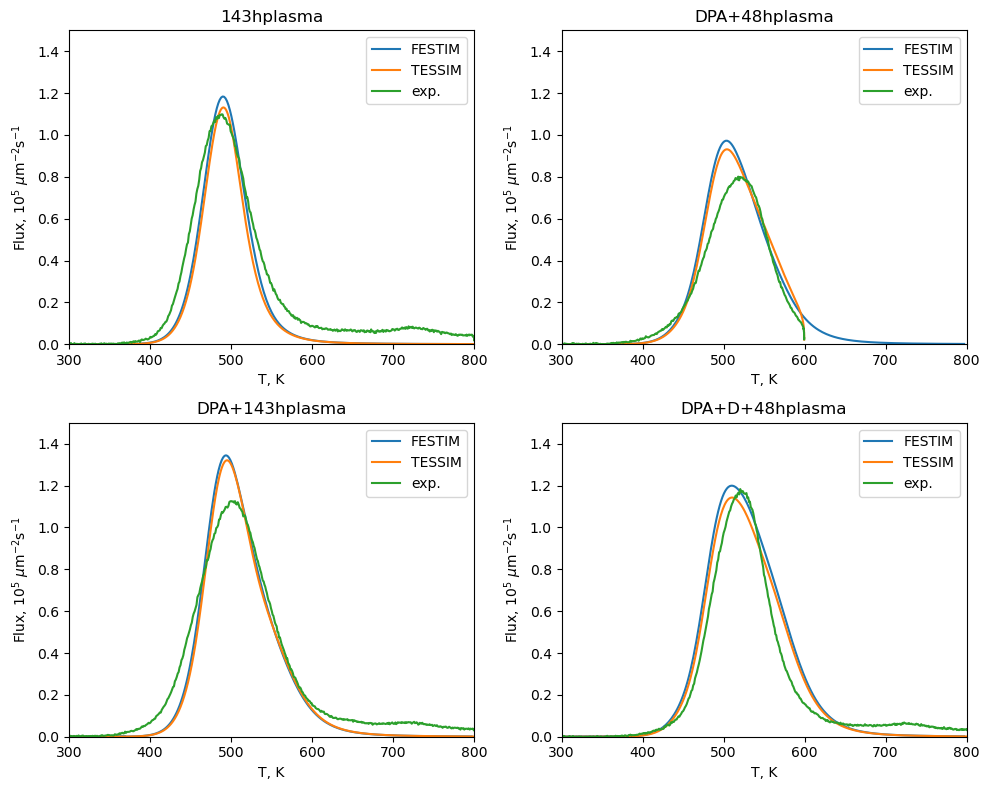

In [1]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import warnings
from scipy import special
import json

warnings.filterwarnings("ignore")

################### PARAMETERS ###################
N_A_const = 6.022e23  # Avogadro, mol^-1
e = 1.602e-19
M_D2 = 4.028e-3 / N_A_const  # the D2 mass, kg mol^-1

# Exposure conditions
P_D2 = 1  # Pa
T_load = 370  # D loading temperature, K
T_storage = 290  # temperature after cooling phase, K
ramp = 3 / 60  # TDS heating rate, K/s
# t_load = 143 * 3600  # exposure duration, s
t_cool = 1000  # colling duration, s
t_storage = 24 * 3600  # storage time, s
t_TDS = (800 - T_storage) / ramp  # TDS duration (up to 800 K), s
# cooling_rate = (T_load - T_storage) / t_cool  # cooling rate, K/s

# Sample
L = 0.8e-3  # half thickness, m

# EUROFER properties
rho_EFe = 8.59e28  # EUROFER atomic concentration, m^-3
n_IS = 6 * rho_EFe  # concentration of interstitial sites, m^-3
n_surf = rho_EFe ** (2 / 3)  # concentration of adsorption sites, m^-2
lambda_lat = rho_EFe ** (-1 / 3)  # Typical lattice spacing, m

D0 = 1.5e-7  # diffusivity pre-factor, m^2 s^-1
E_diff = 0.15  # diffusion activation energy, eV

# Energy landscape
E_bs = E_diff  # energy barrier from bulk to surface transition, eV
nu_bs = D0 / lambda_lat**2  # attempt frequency for b-to-s transition, s^-1
E_diss = 0.4  # energy barrier for D2 dissociation, eV
E_rec = 0.63  # energy barrier for D2 recombination, eV
E_sol = 0.238  # heat of solution, eV
S0 = 1.5e-6
Xi0 = 1e-5
chi0 = 1e-7
E_sb = (
    E_rec / 2 - E_diss / 2 + 0.238 + E_diff
)  # energy barrier from bulk to surface transition, eV

# Trap properties
nu_tr = D0 / lambda_lat**2  # trapping attempt frequency, s^-1
nu_dt = 4.0e13  # detrapping attempt frequency, s^-1
E_tr = E_diff
E_dt_intr = 0.9  # detrapping energy for intrinsic traps, eV
E_dt_dpa = 1.08  # detrapping energy for DPA traps, eV

# Implantation parameters
Gamma = 9e19  # irradiation flux, m^-2 s^-1
R = -1.0e-10  # implantation range, m
# sigma = 2.35e-10 # standart deviation, m
sigma = 7.5e-10 / np.sqrt(2)

r = 0.612  # reflection coefficient


################### FUNCTIONS ###################
def Xi(T):
    # unitless
    return Xi0 * f.exp(-E_diss / F.k_B / T)


def chi(T):
    # in m^2 s^-1
    return chi0 * f.exp(-E_rec / F.k_B / T)


def S(T):
    # solubility
    return S0 * f.exp(-E_sol / F.k_B / T)


def Psi(T):
    return 1 / f.sqrt(2 * np.pi * M_D2 * F.k_B * T * e)


def k_bs(T, surf_conc, t):
    return nu_bs * f.exp(-E_bs / F.k_B / T) * 6


def k_sb(T, surf_conc, t):
    # see eqs. (13-14) in K. Schmid and M. Zibrov 2021 Nucl. Fusion 61 086008
    return (
        nu_bs
        * f.exp(-E_bs / F.k_B / T)
        * S(T)
        * n_surf
        * f.sqrt(chi(T) / Psi(T) / Xi(T))
    )


def norm_flux(X, sigma):
    return 2 / (1 + special.erf(X / np.sqrt(2) / sigma))


################### MODEL ###################
def run_simulation(t_load, is_dpa, dpa_conc):

    def J_vs(T, surf_conc, t):

        tt = 0.002 * (t - t_load)
        cond = 0.5 - 0.5 * (f.exp(2 * tt) - 1) / (f.exp(2 * tt) + 1)

        J_diss = (
            2 * P_D2 * Xi(T) * (1 - surf_conc / n_surf) ** 2 * Psi(T)
        )  # dissociation flux

        J_rec = 2 * chi(T) * surf_conc**2  # recombination flux

        Omega_loss = 1.4e5
        J_loss = (
            (surf_conc / n_surf) * Omega_loss * Gamma * (1 - r)
        )  # ad hoc flux for fit

        J_net = (J_diss - J_loss) * cond - J_rec
        return J_net

    def J_vs_r(T, surf_conc, t):

        tt = 0.002 * (t - t_load)
        cond = 0.5 - 0.5 * (f.exp(2 * tt) - 1) / (f.exp(2 * tt) + 1)

        J_diss = (
            2 * 1e-12 * Xi(T) * (1 - surf_conc / n_surf) ** 2 * Psi(T)
        )  # dissociation flux

        J_rec = 2 * chi(T) * surf_conc**2  # recombination flux

        J_net = J_diss * cond - J_rec
        return J_net

    EFe_model = F.Simulation(log_level=40)

    # Mesh
    vertices = np.concatenate(
        [
            np.linspace(0, 1e-8, num=100),
            np.linspace(1e-8, 4e-6, num=200),
            np.linspace(4e-6, L - 1e-8, num=250),
            np.linspace(L - 1e-8, L, num=100),
        ]
    )

    EFe_model.mesh = F.MeshFromVertices(np.sort(vertices))

    EFe_model.materials = [F.Material(id=1, D_0=D0, E_D=E_diff)]

    surf_conc1 = F.SurfaceKinetics(
        k_sb=k_sb,
        k_bs=k_bs,
        lambda_IS=lambda_lat,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=0,
        t=F.t,
    )

    surf_conc2 = F.SurfaceKinetics(
        k_sb=k_sb,
        k_bs=k_bs,
        lambda_IS=lambda_lat,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs_r,
        surfaces=2,
        initial_condition=0,
        t=F.t,
    )

    EFe_model.boundary_conditions = [surf_conc1, surf_conc2]

    trap_intr = F.Trap(
        k_0=nu_tr / n_IS,
        E_k=E_tr,
        p_0=nu_dt,
        E_p=E_dt_intr,
        density=1e-5 * rho_EFe,
        materials=EFe_model.materials[0],
    )
    trap_dpa = F.Trap(
        k_0=nu_tr / n_IS,
        E_k=E_tr,
        p_0=nu_dt,
        E_p=E_dt_dpa,
        density=(
            dpa_conc
            + (1e-12 - dpa_conc) * (0.5 + 0.5 * sp.tanh(100e6 * (F.x - 3.3e-6)))
        )
        * rho_EFe,
        materials=EFe_model.materials[0],
    )

    EFe_model.traps = [trap_intr]
    if is_dpa:
        EFe_model.traps.append(trap_dpa)

    EFe_model.sources = [
        F.ImplantationFlux(
            flux=Gamma
            * (1 - r)
            * norm_flux(R, sigma)
            * (0.5 - 0.5 * sp.tanh(0.002 * (F.t - t_load))),
            imp_depth=R,
            width=sigma,
            volume=1,
        )
    ]

    log_bis = sp.Function("std::log")

    a1 = log_bis(sp.cosh(0.005 * (-612700 + (143 * 3600 - t_load) + F.t)))
    a2 = log_bis(sp.cosh(0.005 * (-607300 + (143 * 3600 - t_load) + F.t)))
    a3 = log_bis(sp.cosh(0.005 * (-603200 + (143 * 3600 - t_load) + F.t)))
    a4 = log_bis(sp.cosh(0.005 * (-603200 + (143 * 3600 - t_load) + F.t)))
    a5 = log_bis(sp.cosh(0.005 * (-602200 + (143 * 3600 - t_load) + F.t)))

    fun = (
        293.55
        + 50
        * (
            0
            - 0.05194 * a1
            + 0.05194
            * (
                -3035.806852819440
                - (3035.806852819440 + a1)
                + 2 * (3062.806852819440 + a2)
            )
        )
        + 50
        * (
            0
            - 0.06 * a2
            + 0.06
            * (
                -3020.806852819440
                - (3020.806852819440 + a2)
                + 2 * (3035.806852819440 + a3)
            )
        )
        + 50
        * (
            0
            - 0.04 * a3
            + 0.04
            * (
                -3015.306852819440
                - (3015.306852819440 + a3)
                + 2.00003 * (3020.806852819440 + a4)
            )
        )
        + 50
        * (
            0
            - 0.00339 * a4
            + 0.00339
            * (
                -3010.30685
                - (3010.306852819440 + a4)
                + 2.00009 * (3015.306852819440 + a5)
            )
        )
        + 76.45 * 0.5 * (1 - sp.tanh(0.002 * (F.t - 515800 + (143 * 3600 - t_load))))
    )

    # Monkey patch the C99CodePrinter class
    # this is to avoid the bug obersed in https://github.com/festim-dev/FESTIM/issues/813
    from sympy.printing.c import C99CodePrinter

    original_print_function = C99CodePrinter._print_Function

    def _custom_print_Function(self, expr):
        if expr.func == log_bis:
            return f"std::log({self._print(expr.args[0])})"
        return original_print_function(self, expr)

    C99CodePrinter._print_Function = _custom_print_Function

    EFe_model.T = F.Temperature(
        value=sp.Piecewise(
            (T_load, F.t <= t_load),
            (fun, True),
        )
    )

    def max_step_size(t):
        if t <= t_load:
            return 500
        elif t > t_load and t <= t_load + t_cool + t_storage:
            return 1000
        else:
            return 30

    EFe_model.dt = F.Stepsize(
        initial_value=1e-4,
        stepsize_change_ratio=1.1,
        max_stepsize=max_step_size,
        dt_min=1e-5,
        milestones=[
            t_load,
            t_load + t_cool,
            t_load + t_cool + t_storage,
        ],
    )

    EFe_model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-10,
        maximum_iterations=50,
        final_time=t_load + t_cool + t_storage + t_TDS,
    )

    derived_quantities = F.DerivedQuantities(
        [
            F.AdsorbedHydrogen(surface=1),
            F.AdsorbedHydrogen(surface=2),
            F.TotalSurface(field="T", surface=1),
            F.TotalVolume(field="retention", volume=1),
        ],
    )

    EFe_model.exports = [derived_quantities]

    EFe_model.initialise()
    EFe_model.run()

    return derived_quantities


params = [
    {
        "t_load": 143 * 3600,
        "is_dpa": False,
        "dpa_conc": 0,
        "exp_data": "143hplasma",
    },
    {
        "t_load": 48 * 3600,
        "is_dpa": True,
        "dpa_conc": 2.5e-4,
        "exp_data": "DPA+48hplasma",
    },
    {
        "t_load": 143 * 3600,
        "is_dpa": True,
        "dpa_conc": 2.5e-4,
        "exp_data": "DPA+143hplasma",
    },
    {
        "t_load": 48 * 3600,
        "is_dpa": True,
        "dpa_conc": 5.0e-4,
        "exp_data": "DPA+D+48hplasma",
    },
]

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()

for i, prms in enumerate(params):

    results = run_simulation(
        t_load=prms["t_load"], is_dpa=prms["is_dpa"], dpa_conc=prms["dpa_conc"]
    )

    surf_conc1 = np.array(results[0].data)
    surf_conc2 = np.array(results[1].data)
    T = np.array(results[2].data)
    retention = np.array(results[3].data)
    t = np.array(results.t)

    t_load = prms["t_load"]
    exp_label = prms["exp_data"]

    Flux_left = 2 * surf_conc1**2 * chi0 * np.exp(-E_rec / F.k_B / T)
    Flux_right = 2 * surf_conc2**2 * chi0 * np.exp(-E_rec / F.k_B / T)

    # TESSIM data
    data = json.load(open(f"./TESSIM_data/{exp_label}.json"))

    ax[i].plot(T, (Flux_left + Flux_right) / 1e17, label="FESTIM")

    ax[i].plot(
        np.array(data["temptab"]), np.array(data["simflux"]) / 1e5, label=f"TESSIM"
    )
    ax[i].plot(
        np.array(data["temptab"]), np.array(data["experiment"]) / 1e5, label=f"exp."
    )
    ax[i].set_title(exp_label)

    ax[i].set_xlim(300, 800)
    ax[i].set_ylim(0, 1.5)
    ax[i].set_xlabel("T, K")
    ax[i].set_ylabel(r"Flux, $10^5$ $\mu$m$^{-2}$s$^{-1}$")
    ax[i].legend()

plt.tight_layout()
plt.savefig("./TDS_comparison_with_TESSIM.png")
plt.show()